<a href="https://colab.research.google.com/github/IsaacFigNewton/Analyzing-Hate-Crime-Data/blob/main/Hate_Crime_Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Stuff

###Import all libraries

In [228]:
import pandas as pd
import sklearn as sk
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re

###Import datasets

In [203]:
crime_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/hate_crime/hate_crime.csv", on_bad_lines='skip')
city_demo_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/demographics/city/ACSST1Y2022.S0101-Data.csv", on_bad_lines='skip')
county_demo_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/demographics/county/ACSDP1Y2022.DP05-Data.csv", on_bad_lines='skip')
shared_demo_columns = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/demographics/shared_columns.csv", on_bad_lines='skip')

#Data Cleaning

In [204]:
# use the entries of the first row as the column headers for easier management
def fixHeaders(df):
  new_headers = df.iloc[0]
  new_df = df[1:]
  new_df.columns = new_headers
  return new_df

In [205]:
#fix the headers
city_demo_df = fixHeaders(city_demo_df)
county_demo_df = fixHeaders(county_demo_df)

In [206]:
def split_area_name(area):
    result = [np.nan, np.nan, np.nan]
    if ", " in area:
        result = area.split(", ") + [np.nan]
    if " city" in result[0].lower():
        result[0] = result[0][0:-5]
        result[2] = result[1]
        result[1] = "City"
    elif " county" in result[0].lower():
        result[0] = result[0][0:-7]
        result[2] = result[1]
        result[1] = "County"

    return result + [np.nan] * (3 - len(result))

def splitArea(df):
    df[["pug_agency_name", "agency_type_name", "state_name"]] = df["Geographic Area Name"].map(split_area_name).apply(pd.Series)

In [207]:
splitArea(city_demo_df)
splitArea(county_demo_df)

city_demo_df.head()

,Geography,Geographic Area Name,Estimate!!Total!!Total population,Margin of Error!!Total!!Total population,Estimate!!Total!!Total population!!AGE!!Under 5 years,Margin of Error!!Total!!Total population!!AGE!!Under 5 years,Estimate!!Total!!Total population!!AGE!!5 to 9 years,Margin of Error!!Total!!Total population!!AGE!!5 to 9 years,Estimate!!Total!!Total population!!AGE!!10 to 14 years,Margin of Error!!Total!!Total population!!AGE!!10 to 14 years,...,Estimate!!Percent Female!!Total population!!SUMMARY INDICATORS!!Child dependency ratio,Margin of Error!!Percent Female!!Total population!!SUMMARY INDICATORS!!Child dependency ratio,Estimate!!Percent Female!!Total population!!PERCENT ALLOCATED!!Sex,Margin of Error!!Percent Female!!Total population!!PERCENT ALLOCATED!!Sex,Estimate!!Percent Female!!Total population!!PERCENT ALLOCATED!!Age,Margin of Error!!Percent Female!!Total population!!PERCENT ALLOCATED!!Age,NaN,pug_agency_name,agency_type_name,state_name
1,1600000US0103076,"Auburn city, Alabama",80009,20,3657,1311,3809,1134,4348,1136,...,(X),(X),(X),(X),(X),(X),NaN,Auburn,City,Alabama
2,1600000US0107000,"Birmingham city, Alabama",196353,868,11495,2020,11631,2173,9404,2476,...,(X),(X),(X),(X),(X),(X),NaN,Birmingham,City,Alabama
3,1600000US0121184,"Dothan city, Alabama",70524,678,4549,468,5059,662,4146,592,...,(X),(X),(X),(X),(X),(X),NaN,Dothan,City,Alabama
4,1600000US0135896,"Hoover city, Alabama",92427,45,5778,1406,5805,1516,7377,2051,...,(X),(X),(X),(X),(X),(X),NaN,Hoover,City,Alabama
5,1600000US0137000,"Huntsville city, Alabama",222363,2301,12180,1698,13883,1837,10494,1917,...,(X),(X),(X),(X),(X),(X),NaN,Huntsville,City,Alabama


In [249]:
#only consider 2022 crime data from cities and counties
crime_df = crime_df[(crime_df['data_year'] == 2022) & ((crime_df['agency_type_name'] == "City") | (crime_df['agency_type_name'] == "County"))]

###Combine the datasets

In [250]:
#only include entries corresponding to actual incidents
# merged_df = crime_df.merge(city_demo_df, on=["pug_agency_name", "agency_type_name", "state_name"], how="left")
# merged_df = merged_df.merge(county_demo_df, on=["pug_agency_name", "agency_type_name", "state_name"], how="left")
# merged_df = merged_df[pd.notna(merged_df['incident_id'])]

# Merge city demographics with crime dataframe
merged_city_df = crime_df.merge(city_demo_df, on=["pug_agency_name", "agency_type_name", "state_name"], how="left")

# Merge county demographics with crime dataframe
merged_county_df = crime_df.merge(county_demo_df, on=["pug_agency_name", "agency_type_name", "state_name"], how="left")

merged_county_df

,incident_id,data_year,ori,pug_agency_name,pub_agency_unit,agency_type_name,state_abbr,state_name,division_name,region_name,population_group_code,population_group_description,incident_date,adult_victim_count,juvenile_victim_count,total_offender_count,adult_offender_count,juvenile_offender_count,offender_race,offender_ethnicity,victim_count,offense_name,total_individual_victims,location_name,bias_desc,victim_types,multiple_offense,multiple_bias,Geography,Geographic Area Name,Estimate!!SEX AND AGE!!Total population,Margin of Error!!SEX AND AGE!!Total population,Estimate!!SEX AND AGE!!Total population!!Male,Margin of Error!!SEX AND AGE!!Total population!!Male,Estimate!!SEX AND AGE!!Total population!!Female,Margin of Error!!SEX AND AGE!!Total population!!Female,Estimate!!SEX AND AGE!!Total population!!Sex ratio (males per 100 females),Margin of Error!!SEX AND AGE!!Total population!!Sex ratio (males per 100 females),Estimate!!SEX AND AGE!!Total population!!Under 5 years,Margin of Error!!SEX AND AGE!!Total population!!Under 5 years,Estimate!!SEX AND AGE!!Total population!!5 to 9 years,Margin of Error!!SEX AND AGE!!Total population!!5 to 9 years,Estimate!!SEX AND AGE!!Total population!!10 to 14 years,Margin of Error!!SEX AND AGE!!Total population!!10 to 14 years,Estimate!!SEX AND AGE!!Total population!!15 to 19 years,Margin of Error!!SEX AND AGE!!Total population!!15 to 19 years,Estimate!!SEX AND AGE!!Total population!!20 to 24 years,Margin of Error!!SEX AND AGE!!Total population!!20 to 24 years,Estimate!!SEX AND AGE!!Total population!!25 to 34 years,Margin of Error!!SEX AND AGE!!Total population!!25 to 34 years,Estimate!!SEX AND AGE!!Total population!!35 to 44 years,Margin of Error!!SEX AND AGE!!Total population!!35 to 44 years,Estimate!!SEX AND AGE!!Total population!!45 to 54 years,Margin of Error!!SEX AND AGE!!Total population!!45 to 54 years,Estimate!!SEX AND AGE!!Total population!!55 to 59 years,Margin of Error!!SEX AND AGE!!Total population!!55 to 59 years,Estimate!!SEX AND AGE!!Total population!!60 to 64 years,Margin of Error!!SEX AND AGE!!Total population!!60 to 64 years,Estimate!!SEX AND AGE!!Total population!!65 to 74 years,Margin of Error!!SEX AND AGE!!Total population!!65 to 74 years,Estimate!!SEX AND AGE!!Total population!!75 to 84 years,Margin of Error!!SEX AND AGE!!Total population!!75 to 84 years,Estimate!!SEX AND AGE!!Total population!!85 years and over,Margin of Error!!SEX AND AGE!!Total population!!85 years and over,Estimate!!SEX AND AGE!!Total population!!Median age (years),Margin of Error!!SEX AND AGE!!Total population!!Median age (years),Estimate!!SEX AND AGE!!Total population!!Under 18 years,Margin of Error!!SEX AND AGE!!Total population!!Under 18 years,Estimate!!SEX AND AGE!!Total population!!16 years and over,Margin of Error!!SEX AND AGE!!Total population!!16 years and over,Estimate!!SEX AND AGE!!Total population!!18 years and over,Margin of Error!!SEX AND AGE!!Total population!!18 years and over,Estimate!!SEX AND AGE!!Total population!!21 years and over,Margin of Error!!SEX AND AGE!!Total population!!21 years and over,Estimate!!SEX AND AGE!!Total population!!62 years and over,Margin of Error!!SEX AND AGE!!Total population!!62 years and over,Estimate!!SEX AND AGE!!Total population!!65 years and over,Margin of Error!!SEX AND AGE!!Total population!!65 years and over,Estimate!!SEX AND AGE!!Total population!!18 years and over,Margin of Error!!SEX AND AGE!!Total population!!18 years and over,Estimate!!SEX AND AGE!!Total population!!18 years and over!!Male,Margin of Error!!SEX AND AGE!!Total population!!18 years and over!!Male,Estimate!!SEX AND AGE!!Total population!!18 years and over!!Female,Margin of Error!!SEX AND AGE!!Total population!!18 years and over!!Female,Estimate!!SEX AND AGE!!Total population!!18 years and over!!Sex ratio (males per 100 females),Margin of Error!!SEX AND AGE!!Total population!!18 years and over!!Sex ratio (males per 100 females),Estimate!!SEX AND AGE!!Total population!!65 years and over,

In [251]:
# Create a copy of the crime dataframe
merged_df = crime_df.copy(deep=True)

# Replace NaN values in city and county columns with values from the other dataframe
for id in crime_df["incident_id"]:
    # Check if the incident_id corresponds to a city agency
    if ((crime_df["incident_id"] == id) & (crime_df["agency_type_name"] == "City")).any():
        # Iterate over shared columns and fill NaN values with city data
        for column in shared_demo_columns:
            # Replace NaN values with city data for the specific incident_id
            merged_df.loc[(merged_df["incident_id"] == id) & (merged_df["agency_type_name"] == "City"), column] = \
                merged_city_df.loc[(merged_city_df["incident_id"] == id), column].iloc[0]
    # Check if the incident_id corresponds to a county agency
    elif ((crime_df["incident_id"] == id) & (crime_df["agency_type_name"] == "County")).any():
        # Iterate over shared columns and fill NaN values with county data
        for column in shared_demo_columns:
            # Replace NaN values with county data for the specific incident_id
            merged_df.loc[(merged_df["incident_id"] == id) & (merged_df["agency_type_name"] == "County"), column] = \
                merged_county_df.loc[(merged_county_df["incident_id"] == id), column].iloc[0]

# Remove rows where incident_id is NaN
merged_df = merged_df.dropna(subset=["incident_id"])

KeyboardInterrupt: 

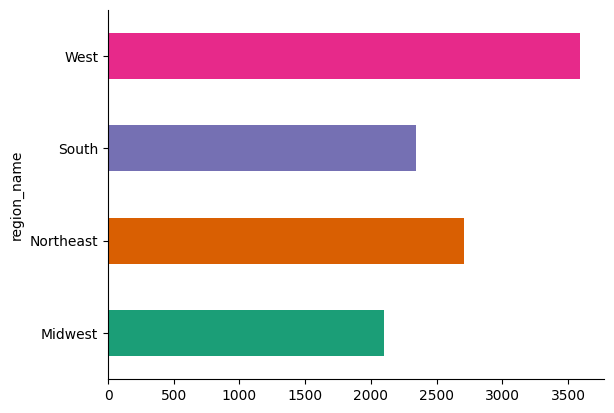

In [252]:
crime_df.groupby('region_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

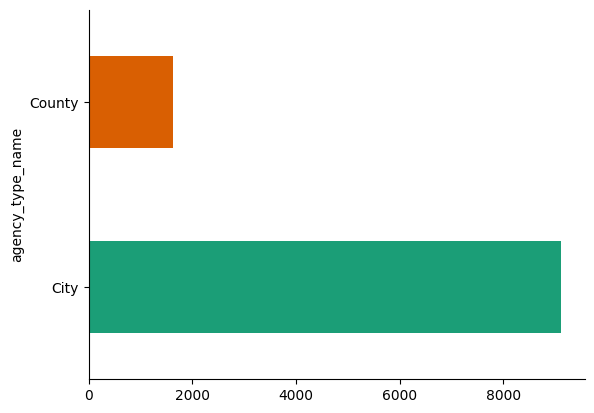

In [253]:
crime_df.groupby('agency_type_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

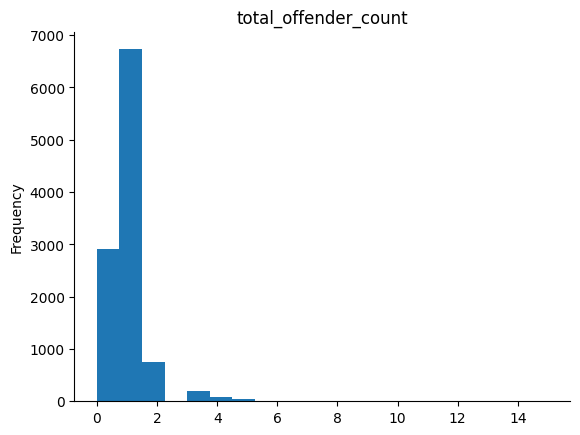

In [254]:
crime_df['total_offender_count'].plot(kind='hist', bins=20, title='total_offender_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

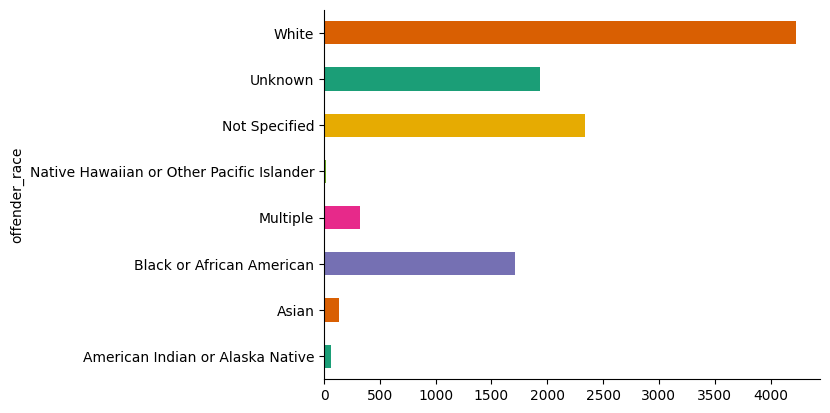

In [255]:
crime_df.groupby('offender_race').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

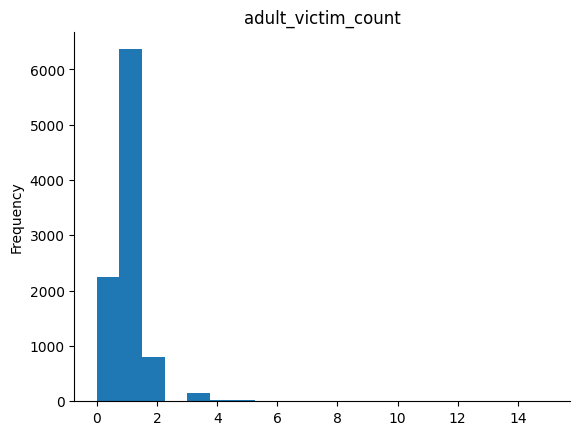

In [256]:
crime_df['adult_victim_count'].plot(kind='hist', bins=20, title='adult_victim_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

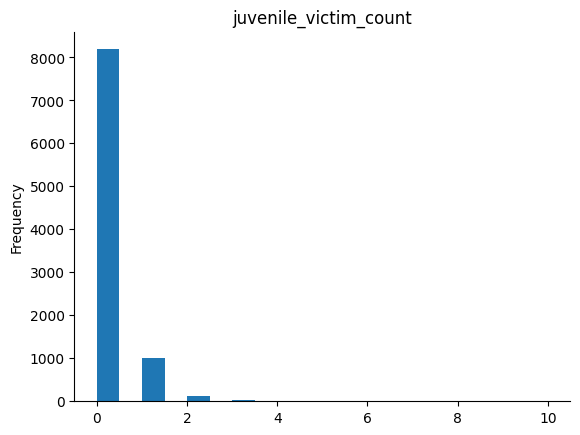

In [257]:
crime_df['juvenile_victim_count'].plot(kind='hist', bins=20, title='juvenile_victim_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

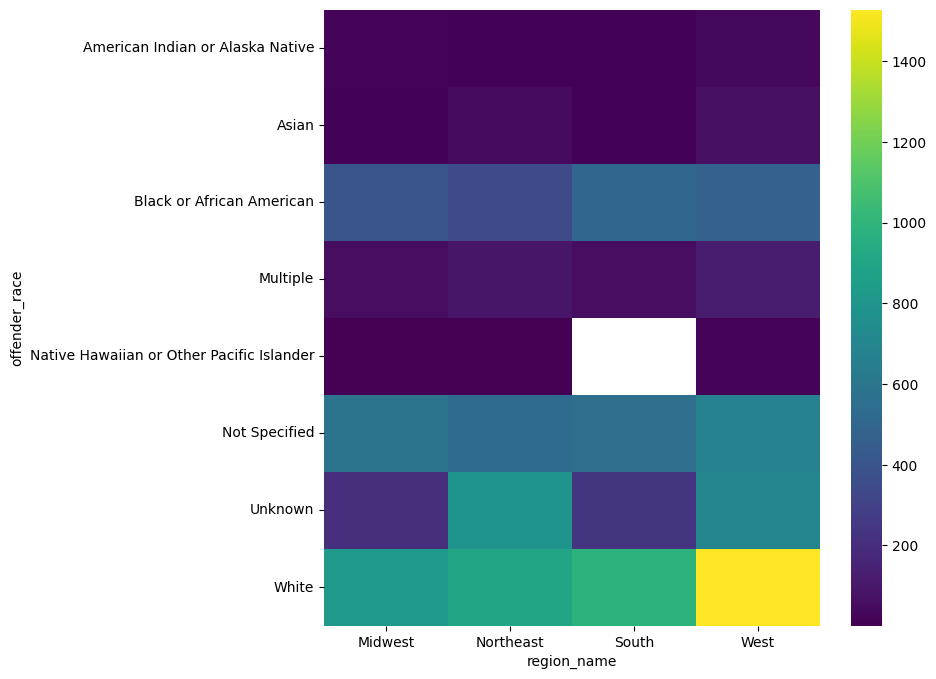

In [258]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['offender_race'].value_counts()
    for x_label, grp in crime_df.groupby('region_name')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('region_name')
_ = plt.ylabel('offender_race')

In [259]:
city_demo_df

,Geography,Geographic Area Name,Estimate!!Total!!Total population,Margin of Error!!Total!!Total population,Estimate!!Total!!Total population!!AGE!!Under 5 years,Margin of Error!!Total!!Total population!!AGE!!Under 5 years,Estimate!!Total!!Total population!!AGE!!5 to 9 years,Margin of Error!!Total!!Total population!!AGE!!5 to 9 years,Estimate!!Total!!Total population!!AGE!!10 to 14 years,Margin of Error!!Total!!Total population!!AGE!!10 to 14 years,Estimate!!Total!!Total population!!AGE!!15 to 19 years,Margin of Error!!Total!!Total population!!AGE!!15 to 19 years,Estimate!!Total!!Total population!!AGE!!20 to 24 years,Margin of Error!!Total!!Total population!!AGE!!20 to 24 years,Estimate!!Total!!Total population!!AGE!!25 to 29 years,Margin of Error!!Total!!Total population!!AGE!!25 to 29 years,Estimate!!Total!!Total population!!AGE!!30 to 34 years,Margin of Error!!Total!!Total population!!AGE!!30 to 34 years,Estimate!!Total!!Total population!!AGE!!35 to 39 years,Margin of Error!!Total!!Total population!!AGE!!35 to 39 years,Estimate!!Total!!Total population!!AGE!!40 to 44 years,Margin of Error!!Total!!Total population!!AGE!!40 to 44 years,Estimate!!Total!!Total population!!AGE!!45 to 49 years,Margin of Error!!Total!!Total population!!AGE!!45 to 49 years,Estimate!!Total!!Total population!!AGE!!50 to 54 years,Margin of Error!!Total!!Total population!!AGE!!50 to 54 years,Estimate!!Total!!Total population!!AGE!!55 to 59 years,Margin of Error!!Total!!Total population!!AGE!!55 to 59 years,Estimate!!Total!!Total population!!AGE!!60 to 64 years,Margin of Error!!Total!!Total population!!AGE!!60 to 64 years,Estimate!!Total!!Total population!!AGE!!65 to 69 years,Margin of Error!!Total!!Total population!!AGE!!65 to 69 years,Estimate!!Total!!Total population!!AGE!!70 to 74 years,Margin of Error!!Total!!Total population!!AGE!!70 to 74 years,Estimate!!Total!!Total population!!AGE!!75 to 79 years,Margin of Error!!Total!!Total population!!AGE!!75 to 79 years,Estimate!!Total!!Total population!!AGE!!80 to 84 years,Margin of Error!!Total!!Total population!!AGE!!80 to 84 years,Estimate!!Total!!Total population!!AGE!!85 years and over,Margin of Error!!Total!!Total population!!AGE!!85 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!5 to 14 years,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!5 to 14 years,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!15 to 17 years,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!15 to 17 years,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!Under 18 years,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!Under 18 years,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 to 24 years,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 to 24 years,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!15 to 44 years,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!15 to 44 years,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!16 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!16 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!21 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!21 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!60 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!60 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!62 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!62 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!65 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!65 years and over,Estimate!!Total!!Total pop

In [260]:
county_demo_df

,Geography,Geographic Area Name,Estimate!!SEX AND AGE!!Total population,Margin of Error!!SEX AND AGE!!Total population,Estimate!!SEX AND AGE!!Total population!!Male,Margin of Error!!SEX AND AGE!!Total population!!Male,Estimate!!SEX AND AGE!!Total population!!Female,Margin of Error!!SEX AND AGE!!Total population!!Female,Estimate!!SEX AND AGE!!Total population!!Sex ratio (males per 100 females),Margin of Error!!SEX AND AGE!!Total population!!Sex ratio (males per 100 females),Estimate!!SEX AND AGE!!Total population!!Under 5 years,Margin of Error!!SEX AND AGE!!Total population!!Under 5 years,Estimate!!SEX AND AGE!!Total population!!5 to 9 years,Margin of Error!!SEX AND AGE!!Total population!!5 to 9 years,Estimate!!SEX AND AGE!!Total population!!10 to 14 years,Margin of Error!!SEX AND AGE!!Total population!!10 to 14 years,Estimate!!SEX AND AGE!!Total population!!15 to 19 years,Margin of Error!!SEX AND AGE!!Total population!!15 to 19 years,Estimate!!SEX AND AGE!!Total population!!20 to 24 years,Margin of Error!!SEX AND AGE!!Total population!!20 to 24 years,Estimate!!SEX AND AGE!!Total population!!25 to 34 years,Margin of Error!!SEX AND AGE!!Total population!!25 to 34 years,Estimate!!SEX AND AGE!!Total population!!35 to 44 years,Margin of Error!!SEX AND AGE!!Total population!!35 to 44 years,Estimate!!SEX AND AGE!!Total population!!45 to 54 years,Margin of Error!!SEX AND AGE!!Total population!!45 to 54 years,Estimate!!SEX AND AGE!!Total population!!55 to 59 years,Margin of Error!!SEX AND AGE!!Total population!!55 to 59 years,Estimate!!SEX AND AGE!!Total population!!60 to 64 years,Margin of Error!!SEX AND AGE!!Total population!!60 to 64 years,Estimate!!SEX AND AGE!!Total population!!65 to 74 years,Margin of Error!!SEX AND AGE!!Total population!!65 to 74 years,Estimate!!SEX AND AGE!!Total population!!75 to 84 years,Margin of Error!!SEX AND AGE!!Total population!!75 to 84 years,Estimate!!SEX AND AGE!!Total population!!85 years and over,Margin of Error!!SEX AND AGE!!Total population!!85 years and over,Estimate!!SEX AND AGE!!Total population!!Median age (years),Margin of Error!!SEX AND AGE!!Total population!!Median age (years),Estimate!!SEX AND AGE!!Total population!!Under 18 years,Margin of Error!!SEX AND AGE!!Total population!!Under 18 years,Estimate!!SEX AND AGE!!Total population!!16 years and over,Margin of Error!!SEX AND AGE!!Total population!!16 years and over,Estimate!!SEX AND AGE!!Total population!!18 years and over,Margin of Error!!SEX AND AGE!!Total population!!18 years and over,Estimate!!SEX AND AGE!!Total population!!21 years and over,Margin of Error!!SEX AND AGE!!Total population!!21 years and over,Estimate!!SEX AND AGE!!Total population!!62 years and over,Margin of Error!!SEX AND AGE!!Total population!!62 years and over,Estimate!!SEX AND AGE!!Total population!!65 years and over,Margin of Error!!SEX AND AGE!!Total population!!65 years and over,Estimate!!SEX AND AGE!!Total population!!18 years and over,Margin of Error!!SEX AND AGE!!Total population!!18 years and over,Estimate!!SEX AND AGE!!Total population!!18 years and over!!Male,Margin of Error!!SEX AND AGE!!Total population!!18 years and over!!Male,Estimate!!SEX AND AGE!!Total population!!18 years and over!!Female,Margin of Error!!SEX AND AGE!!Total population!!18 years and over!!Female,Estimate!!SEX AND AGE!!Total population!!18 years and over!!Sex ratio (males per 100 females),Margin of Error!!SEX AND AGE!!Total population!!18 years and over!!Sex ratio (males per 100 females),Estimate!!SEX AND AGE!!Total population!!65 years and over,Margin of Error!!SEX AND AGE!!Total population!!65 years and over,Estimate!!SEX AND AGE!!Total population!!65 years and over!!Male,Margin of Error!!SEX AND AGE!!Total population!!65 years and over!!Male,Estimate!!SEX AND AGE!!Total population!!65 years and over!!Female,Margin of Error!!SEX AND AGE!!Total population!!65 years and over!!Female,Estimate!!SEX AND AGE!!Total population!!65 years and over!!Sex ratio (males per 100 females),Margin of